In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score
from sklearn.preprocessing import  StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay



In [2]:
# '\s+' tells pandas to use any spaces as the delimiter instead of ,
train_df = pd.read_csv("../data/train.2024.04.16.csv")

In [3]:
feature_col_names = ['F01', 'F02', 'F03', 'F04',
       'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13']

In [4]:
train_df

,Unnamed: 0,Date,Time,Elat,Elon,Dep,Tag,F01,F02,F03,...,F05,F06,F07,F08,F09,F10,F11,F12,F13,y
0,5789,2020-04-21,01:26:21.92,40.748,-111.969,6.3,eq,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,9139,2022-09-10,01:50:17.85,39.426,-110.301,-1.9,mis,NaN,NaN,-0.04,...,-141.5,NaN,12.17,NaN,NaN,NaN,NaN,NaN,0.25,2
2,8625,2022-06-28,06:00:23.98,39.430,-110.301,-1.7,mis,-0.34,NaN,0.32,...,-145.1,NaN,12.54,NaN,NaN,NaN,NaN,NaN,NaN,2
3,6106,2020-05-28,08:24:24.05,38.758,-111.494,6.4,eq,-0.37,NaN,0.34,...,-100.8,NaN,14.15,NaN,NaN,NaN,NaN,NaN,0.05,1
4,978,2014-06-17,16:43:49.18,39.542,-111.718,12.2,eq,NaN,NaN,0.96,...,-96.6,NaN,15.23,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,6784,2020-12-18,19:38:50.61,37.547,-113.062,5.5,eq,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7532,1267,2015-01-14,20:56:48.63,38.965,-112.912,-2.0,ex,0.26,0.60,0.81,...,-79.5,13.86,12.10,NaN,NaN,NaN,NaN,NaN,NaN,0
7533,2306,2017-03-30,02:33:56.25,39.626,-112.174,-2.0,ex,0.00,0.13,-0.13,...,-114.1,14.09,13.63,0.2,0.36,0.27,0.41,0.13,0.42,0
7534,4555,2020-03-19,13:36:34.83,40.744,-112.035,7.6,eq,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Look for near-zero variance features

**Should probably do this on the whole dataset because unsupervised**


Looking for features where:

> - The fraction of unique values over the sample size is low (say 10 %).
> - The ratio of the frequency of the most prevalent value to the frequency of
the second most prevalent value is large (say around 20).  
> \- APM, p. 45



In [5]:
for col in feature_col_names:
    print(col)
    cnt = train_df[col].unique().shape[0]
    print(f"Entire dataset: {(cnt/train_df.shape[0])*100:0.1f}%")
    print(f"With feature: {(cnt/(train_df[col] != "X").sum())*100:0.1f}%")
    value_counts = train_df.copy().replace(to_replace='X', value=np.nan)[col].astype(float).value_counts().reset_index()['count']
    print(f"Feat1:Feat2: {value_counts[0]/value_counts[1]: 0.2f}")

F01
Entire dataset: 2.5%
With feature: 2.5%
Feat1:Feat2:  1.06
F02
Entire dataset: 2.9%
With feature: 2.9%
Feat1:Feat2:  1.16
F03
Entire dataset: 3.4%
With feature: 3.4%
Feat1:Feat2:  1.02
F04
Entire dataset: 11.4%
With feature: 11.4%
Feat1:Feat2:  1.00
F05
Entire dataset: 13.0%
With feature: 13.0%
Feat1:Feat2:  1.12
F06
Entire dataset: 6.7%
With feature: 6.7%
Feat1:Feat2:  1.07
F07
Entire dataset: 6.9%
With feature: 6.9%
Feat1:Feat2:  1.04
F08
Entire dataset: 1.1%
With feature: 1.1%
Feat1:Feat2:  1.09
F09
Entire dataset: 1.2%
With feature: 1.2%
Feat1:Feat2:  1.00
F10
Entire dataset: 1.2%
With feature: 1.2%
Feat1:Feat2:  1.11
F11
Entire dataset: 1.4%
With feature: 1.4%
Feat1:Feat2:  1.24
F12
Entire dataset: 1.8%
With feature: 1.8%
Feat1:Feat2:  1.00
F13
Entire dataset: 2.2%
With feature: 2.2%
Feat1:Feat2:  1.08


In [6]:
train_df[feature_col_names].describe().loc['std']**2

F01      0.091115
F02      0.158292
F03      0.153732
F04    496.544232
F05    507.537255
F06      1.612158
F07      1.455926
F08      0.015624
F09      0.027954
F10      0.024279
F11      0.025960
F12      0.082744
F13      0.098343
Name: std, dtype: float64

In [7]:
all_feats_df = train_df[~np.any(np.isnan(train_df[feature_col_names]), axis=1)]
X = all_feats_df[feature_col_names].to_numpy()
y = all_feats_df["y"].to_numpy()

# Try LDA transform method using all features

In [8]:
# Try scaling
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [9]:
ldaAll = LDA(n_components=2)
ldaAll.fit(X_scaled, y)
y_pred_all = ldaAll.predict(X_scaled)

In [10]:
f1_score(y, y_pred_all, average='macro')

0.9401611020466496

In [11]:
X_reduced = ldaAll.transform(X_scaled)

In [12]:
ldaReduced = LDA()
ldaReduced.fit(X_reduced, y)

LinearDiscriminantAnalysis()

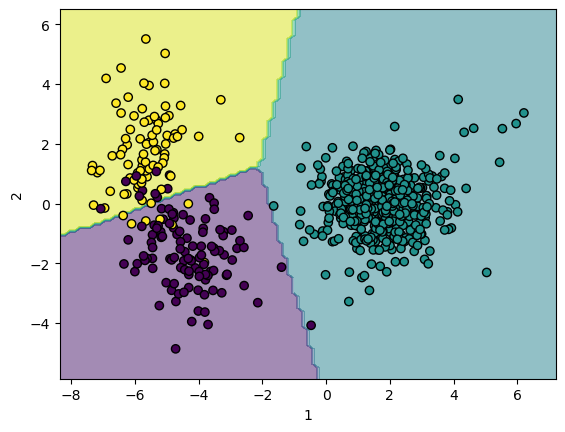

In [13]:
disp = DecisionBoundaryDisplay.from_estimator(
    ldaReduced, X_reduced, response_method="predict",
    xlabel="1", ylabel="2",
    alpha=0.5,
)
disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolor="k")
plt.show()

In [81]:
ldaAll.explained_variance_ratio_

array([0.92329687, 0.07670313])

In [90]:
ldaAll.scalings_

array([[-2.92141348e-01, -6.90384961e-01],
       [ 6.53440338e-01, -2.27497104e-01],
       [ 4.37441511e-01,  8.02892780e-01],
       [-3.43363826e-01, -2.73977807e-01],
       [ 1.23354697e-03, -1.58230574e-01],
       [ 4.70953955e-01,  2.44408018e-01],
       [ 1.13284842e+00, -6.86252966e-02],
       [ 1.75237205e-01, -2.62934379e-01],
       [-5.64163353e-01,  1.90410477e+00],
       [-7.57859437e-02, -1.42720212e+00],
       [ 6.45102666e-02, -5.19089550e-01],
       [-4.07149936e-02, -4.08843197e-01],
       [-7.68281639e-01,  7.12263860e-01]])

In [88]:
np.argsort(abs(ldaAll.scalings_[:, 0]))+1

array([ 5, 12, 11, 10,  8,  1,  4,  3,  6,  9,  2, 13,  7])

In [110]:
np.argsort(abs(ldaAll.scalings_[:, 1]))+1

array([ 7,  5,  2,  6,  8,  4, 12, 11,  1, 13,  3, 10,  9])

In [111]:
np.sort(abs(ldaAll.scalings_[:, 0]))

array([0.00123355, 0.04071499, 0.06451027, 0.07578594, 0.17523721,
       0.29214135, 0.34336383, 0.43744151, 0.47095396, 0.56416335,
       0.65344034, 0.76828164, 1.13284842])

In [112]:
np.sort(abs(ldaAll.scalings_[:, 1]))

array([0.0686253 , 0.15823057, 0.2274971 , 0.24440802, 0.26293438,
       0.27397781, 0.4088432 , 0.51908955, 0.69038496, 0.71226386,
       0.80289278, 1.42720212, 1.90410477])

Text(0.5, 1.0, 'All features')

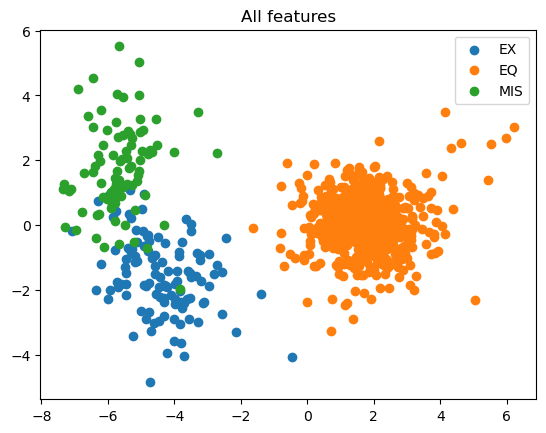

In [140]:
tmp = np.dot(X_scaled, ldaAll.scalings_)
plt.scatter(tmp[y==0][:, 0], tmp[y==0][:, 1], label="EX")
plt.scatter(tmp[y==1][:, 0], tmp[y==1][:, 1], label="EQ")
plt.scatter(tmp[y==2][:, 0], tmp[y==2][:, 1], label="MIS")
plt.legend()
plt.title("All features")

Text(0.5, 1.0, 'Remove feature 7')

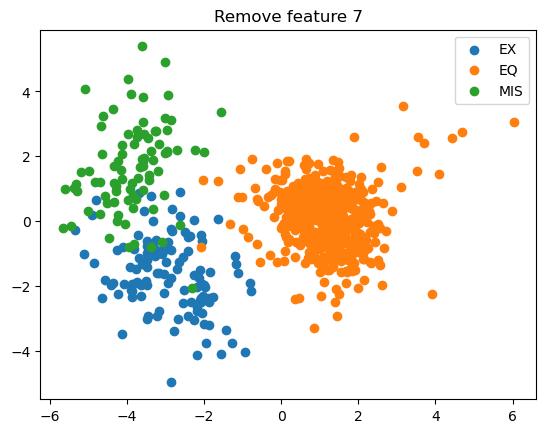

In [107]:
filt_inds = np.delete(np.arange(0, 13), [6])
X_filtered = X_scaled[:, filt_inds]
tmp = np.dot(X_filtered, ldaAll.scalings_[filt_inds, :])
plt.scatter(tmp[y==0][:, 0], tmp[y==0][:, 1], label="EX")
plt.scatter(tmp[y==1][:, 0], tmp[y==1][:, 1], label="EQ")
plt.scatter(tmp[y==2][:, 0], tmp[y==2][:, 1], label="MIS")
plt.legend()
plt.title("Remove feature 7")

Text(0.5, 1.0, 'Remove feature 13')

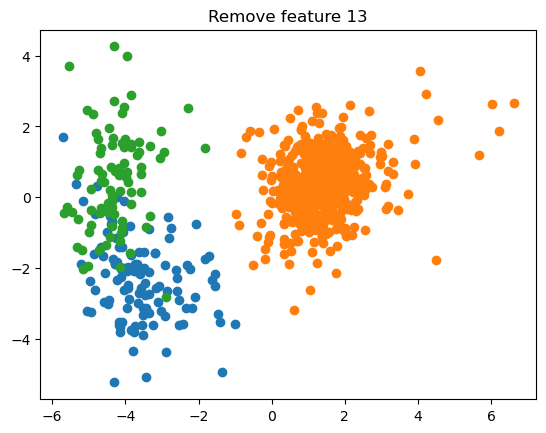

In [97]:
filt_inds = np.delete(np.arange(0, 13), [12])
X_filtered = X_scaled[:, filt_inds]
tmp = np.dot(X_filtered, ldaAll.scalings_[filt_inds, :])
plt.scatter(tmp[y==0][:, 0], tmp[y==0][:, 1])
plt.scatter(tmp[y==1][:, 0], tmp[y==1][:, 1])
plt.scatter(tmp[y==2][:, 0], tmp[y==2][:, 1])
plt.title("Remove feature 13")

Text(0.5, 1.0, 'Remove feature 9')

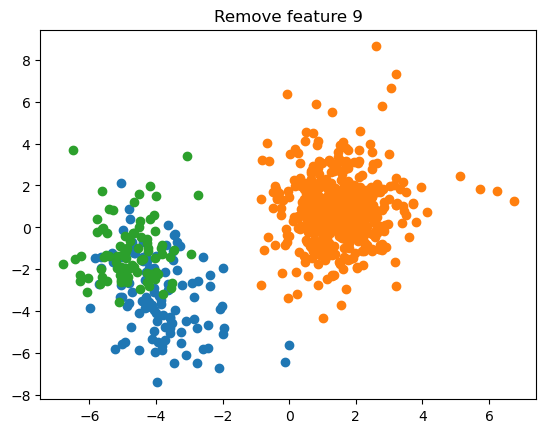

In [139]:
filt_inds = np.delete(np.arange(0, 13), [8])
X_filtered = X_scaled[:, filt_inds]
tmp = np.dot(X_filtered, ldaAll.scalings_[filt_inds, :])
plt.scatter(tmp[y==0][:, 0], tmp[y==0][:, 1])
plt.scatter(tmp[y==1][:, 0], tmp[y==1][:, 1])
plt.scatter(tmp[y==2][:, 0], tmp[y==2][:, 1])
plt.title("Remove feature 9")

Text(0.5, 1.0, 'Feature 7')

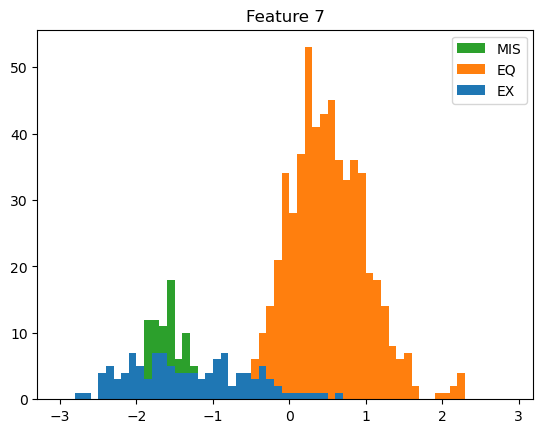

In [114]:
feat_ind = 6
bins = np.arange(-3, 3, 0.1)
plt.hist(X_scaled[y==2, feat_ind], bins=bins, color='C2', label="MIS");
plt.hist(X_scaled[y==1, feat_ind], bins=bins, color="C1", label="EQ");
plt.hist(X_scaled[y==0, feat_ind], bins=bins, color="C0", label="EX");
plt.legend()
plt.title("Feature 7")

Text(0.5, 1.0, 'Feature 13')

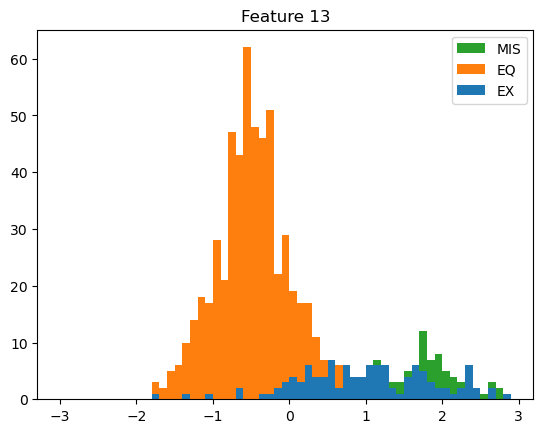

In [116]:
feat_ind = 12
bins = np.arange(-3, 3, 0.1)
plt.hist(X_scaled[y==2, feat_ind], bins=bins, color='C2', label="MIS");
plt.hist(X_scaled[y==1, feat_ind], bins=bins, color="C1", label="EQ");
plt.hist(X_scaled[y==0, feat_ind], bins=bins, color="C0", label="EX");

plt.legend()
plt.title("Feature 13")


Text(0.5, 1.0, 'Feature 9')

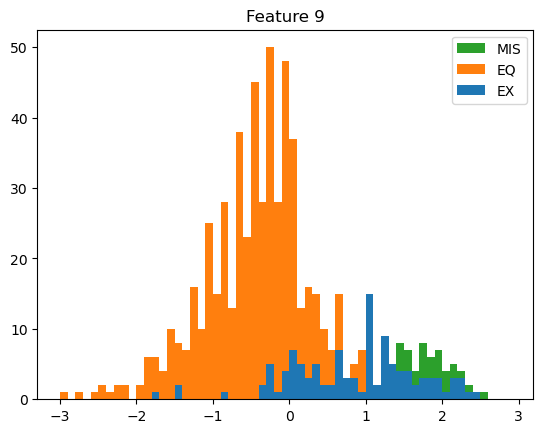

In [138]:
feat_ind = 8
bins = np.arange(-3, 3, 0.1)
plt.hist(X_scaled[y==2, feat_ind], bins=bins, color='C2', label="MIS");
plt.hist(X_scaled[y==1, feat_ind], bins=bins, color="C1", label="EQ");
plt.hist(X_scaled[y==0, feat_ind], bins=bins, color="C0", label="EX");

plt.legend()
plt.title("Feature 9")

Text(0.5, 1.0, 'Feature 10')

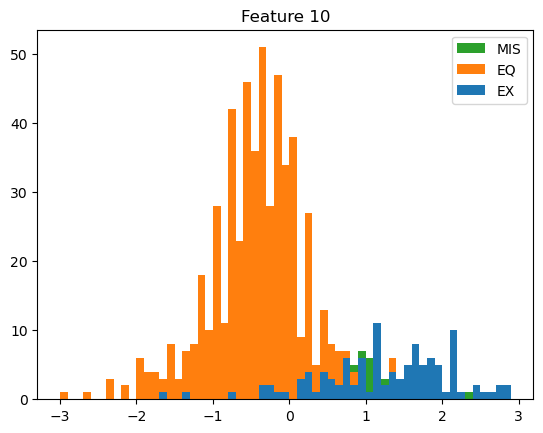

In [189]:
feat_ind = 9
bins = np.arange(-3, 3, 0.1)
plt.hist(X_scaled[y==2, feat_ind], bins=bins, color='C2', label="MIS");
plt.hist(X_scaled[y==1, feat_ind], bins=bins, color="C1", label="EQ");
plt.hist(X_scaled[y==0, feat_ind], bins=bins, color="C0", label="EX");

plt.legend()
plt.title("Feature 10")

Text(0.5, 1.0, 'Feature 1')

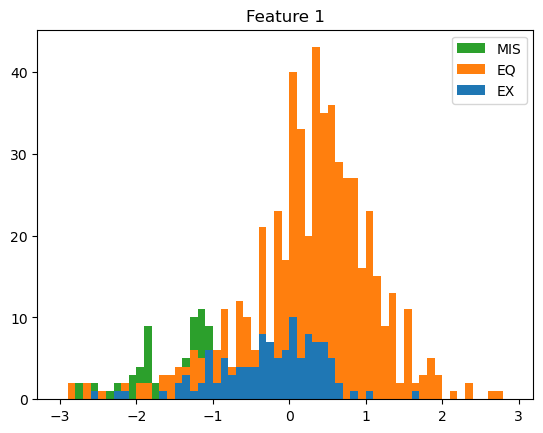

In [193]:
feat_ind = 0
bins = np.arange(-3, 3, 0.1)
plt.hist(X_scaled[y==2, feat_ind], bins=bins, color='C2', label="MIS");
plt.hist(X_scaled[y==1, feat_ind], bins=bins, color="C1", label="EQ");
plt.hist(X_scaled[y==0, feat_ind], bins=bins, color="C0", label="EX");

plt.legend()
plt.title("Feature 1")

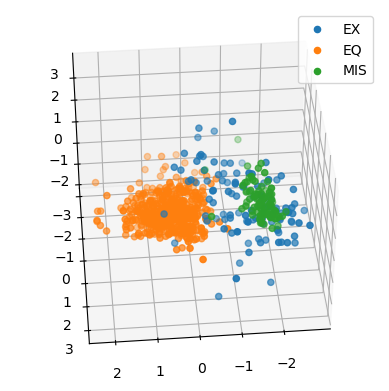

In [170]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_scaled[y == 0][:, 6], X_scaled[y==0][:, 8], X_scaled[y==0][:, 12], label='EX')
ax.scatter(X_scaled[y == 1][:, 6], X_scaled[y==1][:, 8], X_scaled[y==1][:, 12], label="EQ")
ax.scatter(X_scaled[y == 2][:, 6], X_scaled[y==2][:, 8], X_scaled[y==2][:, 12], label="MIS")
ax.view_init(elev=40, azim=85, roll=0)
ax.legend()

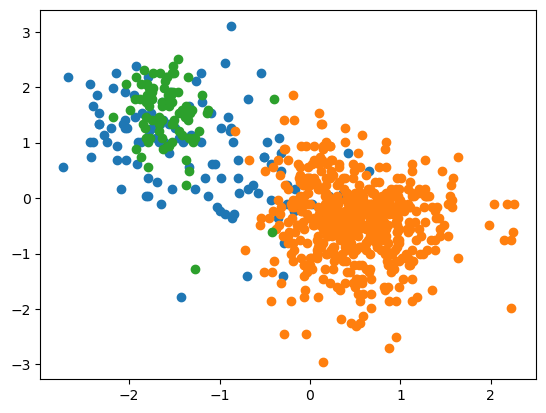

In [172]:
plt.scatter(X_scaled[y==0, 6], X_scaled[y==0, 8])
plt.scatter(X_scaled[y==1, 6], X_scaled[y==1, 8])
plt.scatter(X_scaled[y==2, 6], X_scaled[y==2, 8])

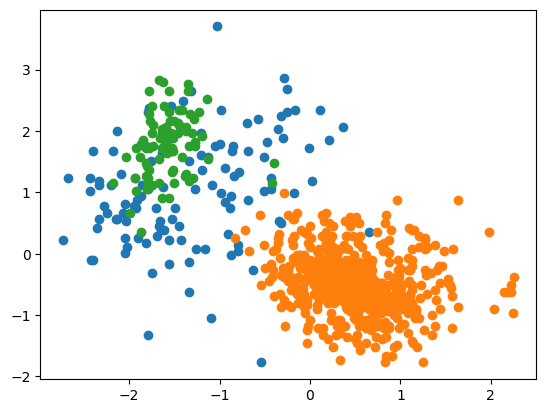

In [174]:
plt.scatter(X_scaled[y==0, 6], X_scaled[y==0, 12])
plt.scatter(X_scaled[y==1, 6], X_scaled[y==1, 12])
plt.scatter(X_scaled[y==2, 6], X_scaled[y==2, 12])

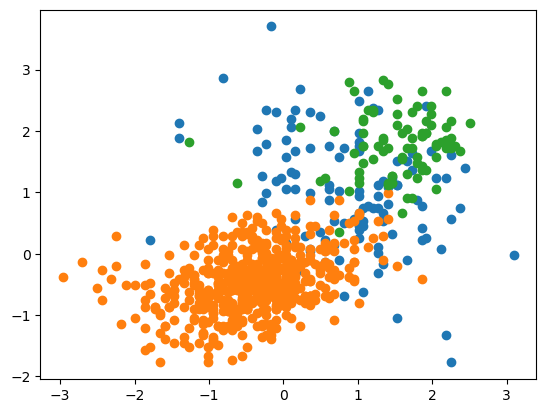

In [175]:
plt.scatter(X_scaled[y==0, 8], X_scaled[y==0, 12])
plt.scatter(X_scaled[y==1, 8], X_scaled[y==1, 12])
plt.scatter(X_scaled[y==2, 8], X_scaled[y==2, 12])

In [192]:
LDA3feat = LDA()
LDA3feat.fit(X[:, [6, 8, 9, 12]], y)
y_pred3feat = LDA3feat.predict(X[:, [6, 8, 9, 12]])
f1_score(y, y_pred3feat, average="macro")

0.8983314065583272

# Do SVD - 2D

In [14]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(X)
X_svd2D = svd.transform(X)


In [15]:
# Try scaling
scaler2D = StandardScaler()
scaler2D.fit(X_svd2D)
X_svd2D = scaler2D.transform(X_svd2D)

In [16]:
# Fit LDA to 2D data
lda2D = LDA()
lda2D.fit(X_svd2D, y)
y_pred_2D = lda2D.predict(X_svd2D)

In [17]:
f1_score(y, y_pred_2D, average='macro')

0.5482661006342362

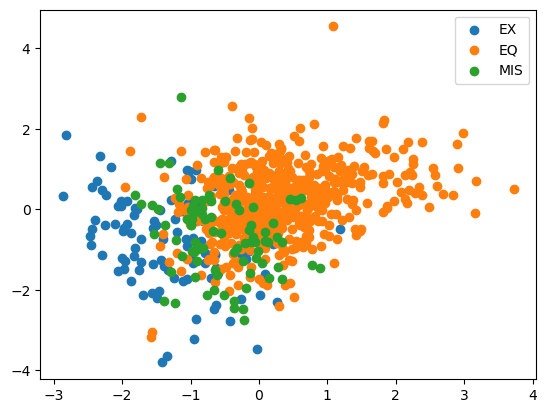

In [18]:
plt.scatter(X_svd2D[y == 0][:, 0], X_svd2D[y==0][:, 1], label='EX')
plt.scatter(X_svd2D[y == 1][:, 0], X_svd2D[y==1][:, 1], label="EQ")
plt.scatter(X_svd2D[y == 2][:, 0], X_svd2D[y==2][:, 1], label="MIS")
plt.legend()

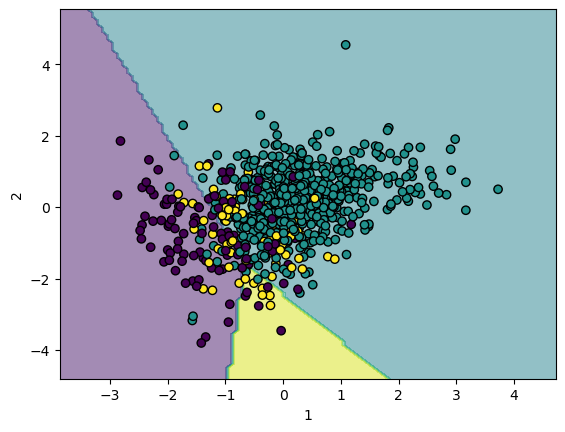

In [19]:
disp = DecisionBoundaryDisplay.from_estimator(
    lda2D, X_svd2D, response_method="predict",
    xlabel="1", ylabel="2",
    alpha=0.5,
)
disp.ax_.scatter(X_svd2D[:, 0], X_svd2D[:, 1], c=y, edgecolor="k")
plt.show()

# PCA

In [20]:
pca = PCA(n_components=2)

In [21]:
pca.fit(X_scaled)

PCA(n_components=2)

In [22]:
pca.components_

array([[-0.21127278, -0.17321759, -0.15340462,  0.24784372,  0.18786979,
        -0.34156588, -0.34190854,  0.24001861,  0.33604094,  0.32886324,
         0.29978303,  0.30521603,  0.33140016],
       [-0.416561  , -0.51740564, -0.53478539, -0.22599859, -0.25267131,
         0.03541907,  0.10511094, -0.23197057, -0.08901004, -0.14459465,
        -0.17438984,  0.15705286,  0.08850872]])

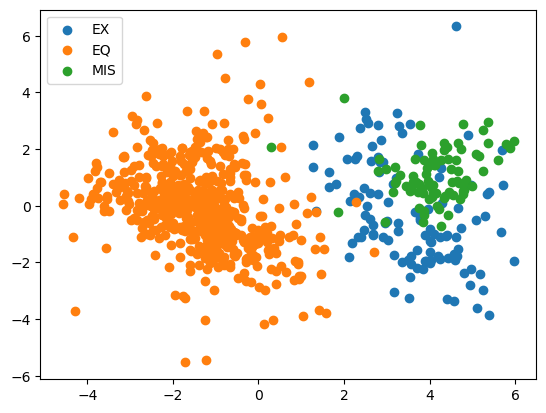

In [23]:
X_pca = pca.transform(X_scaled)

plt.scatter(X_pca[y == 0][:, 0], X_pca[y==0][:, 1], label='EX')
plt.scatter(X_pca[y == 1][:, 0], X_pca[y==1][:, 1], label="EQ")
plt.scatter(X_pca[y == 2][:, 0], X_pca[y==2][:, 1], label="MIS")
plt.legend()

# SVD 3D

In [27]:
svd3D = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
svd3D.fit(X)
X_svd3D = svd3D.transform(X)

In [28]:
# Try scaling
scaler3D = StandardScaler()
scaler3D.fit(X_svd3D)
X_svd3D = scaler3D.transform(X_svd3D)

In [29]:
lda3D = LDA()
lda3D.fit(X_svd3D, y)
y_pred_3D = lda3D.predict(X_svd3D)

In [30]:
f1_score(y, y_pred_3D, average='macro')

0.7341537536146158

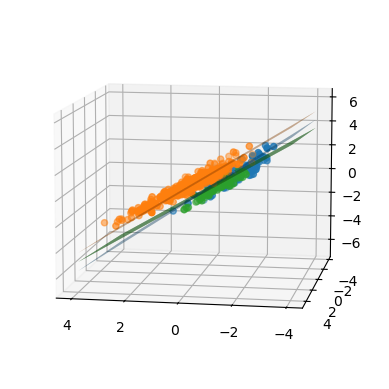

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# x1 = np.array([np.min(X_svd3D[:,0], axis=0), np.max(X_svd3D[:,0], axis=0)])
# x2 = np.array([np.min(X_svd3D[:,1], axis=0), np.max(X_svd3D[:,1], axis=0)])

# for i, c in enumerate(['r','g','b']):
#     b, w1, w2, w3 = model.intercept_[i], model.coef_[i][0], model.coef_[i][1], model.coef_[i][2]
#     y1 = -(b+x1*w1+x2*w2)/w3    
#     plt.plot(x1, x2, y1)

# DB1
z = lambda x1,y1: (-lda3D.intercept_[0]-lda3D.coef_[0][0]*x1-lda3D.coef_[0][1]*y1) / lda3D.coef_[0][2]
x1,y1 = np.meshgrid(np.linspace(-4, 4,51), np.linspace(-4, 4,51))
ax.plot_surface(x1, y1, z(x1,y1), alpha=0.5)
# DB2
z = lambda x1,y1: (-lda3D.intercept_[1]-lda3D.coef_[1][0]*x1-lda3D.coef_[1][1]*y1) / lda3D.coef_[1][2]
ax.plot_surface(x1, y1, z(x1,y1), alpha=0.5)
# DB3
z = lambda x1,y1: (-lda3D.intercept_[2]-lda3D.coef_[2][0]*x1-lda3D.coef_[2][1]*y1) / lda3D.coef_[2][2]
ax.plot_surface(x1, y1, z(x1,y1), alpha=1)

ax.scatter(X_svd3D[y == 0][:, 0], X_svd3D[y==0][:, 1], X_svd3D[y==0][:, 2], label='EX')
ax.scatter(X_svd3D[y == 1][:, 0], X_svd3D[y==1][:, 1], X_svd3D[y==1][:, 2], label="EQ")
ax.scatter(X_svd3D[y == 2][:, 0], X_svd3D[y==2][:, 1], X_svd3D[y==2][:, 2], label="MIS")
ax.view_init(elev=10, azim=100, roll=0)

# Correlations

In [125]:
from sklearn.feature_selection import f_classif

In [129]:
f_statistic, p_values = f_classif(X, y)

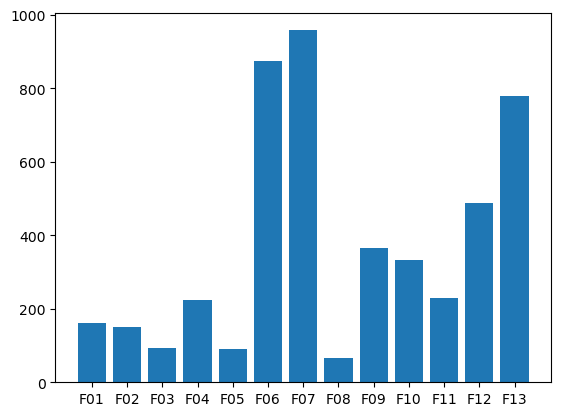

In [130]:
plt.bar(np.arange(X.shape[1]), f_statistic)
plt.xticks(np.arange(X.shape[1]), feature_col_names);

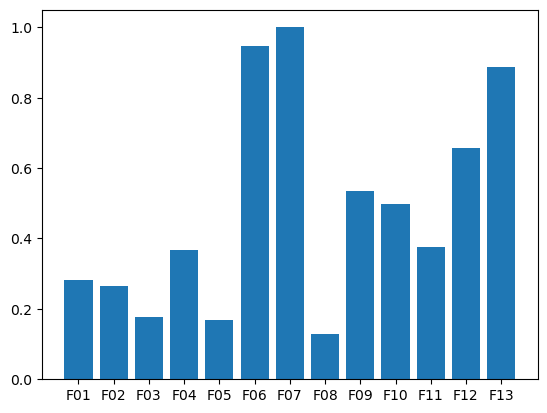

In [133]:
scores = -np.log10(p_values)
scores /= scores.max()
plt.bar(np.arange(X.shape[1]), scores)
plt.xticks(np.arange(X.shape[1]), feature_col_names);